<center>

*******************************************************************************************
<font size="4">
Synchronisation of oscillating fingers under different emotional states <br>
</font>

##### 9 August 2025

##### Juan Ignacio Mendoza Garay

*******************************************************************************************

</center>

##### INFORMATION:

* Attempt to replicate the findings of an experiment described in Smykovskyi et al., (2024) using the same data. The experiment consists of participants (healthy adults) arranged in triads, which were asked to synchronise the oscillation of one of their index fingers. Before each trial they were induced with an emotion (negative, neutral, positive). A reflective marker was placed on the tip of the fingers. The position of the marker was recorded with an infrared motion-capture system. The hypothesis was that the emotions would affect synchronisation. The experiment used two measures derived from the Kuramoto order parameter *r*. The cited paper reports synchronisation levels in the following order from less to more: negative, neutral, positive. However, it is not possible to reproduce the exact methodology of the original experiment, since the descriptions of the methods to obtain thresholds for quartiles, and to compute phase, are incomplete. The results contradict those reported by Smykovskyi et al. The input to this program is preprocessed data produced by Oscillating_Fingers_Prep.ipynb
>
* This program uses the following measures to quantify synchronisation:
    *  Kuramoto order parameter *r* (Strogatz, 2000)
    *  *Rho* statistic (Richardson et al., 2012)
    *  Phase-Locking Values (*PLV*) (Mormann et al., 2000)
>
* References:
    *  Mormann, F., Lehnertz, K., David, P., & Elger, C. E. (2000). Mean phase coherence as a measure for phase synchronization and its application to the EEG of epilepsy patients. *Physica D: Nonlinear Phenomena, 144*(3-4), 358-369. https://doi.org/10.1016/S0167-2789(00)00087-7
    * Richardson, M. J., Garcia, R. L., Frank, T. D., Gergor, M., & Marsh, K. L. (2012). Measuring group synchrony: a cluster-phase method for analyzing multivariate movement time-series. *Frontiers in physiology, 3*, 405. https://doi.org/10.3389/fphys.2012.00405
    * Smykovskyi, A., Janaqi, S., Pla, S., Jean, P., Bieńkiewicz, M., & Bardy, B. G. (2024). Negative emotions disrupt intentional synchronization during group sensorimotor interaction. *Emotion, 24*(3), 687.
    * Smykovskyi, A., Bieńkiewicz, M. M., Pla, S., Janaqi, S., & Bardy, B. G. (2022). Positive emotions foster spontaneous synchronisation in a group movement improvisation task. Frontiers in Human Neuroscience, 16, 944241.
    * Strogatz, S. H. (2000). From Kuramoto to Crawford: exploring the onset of synchronization in populations of coupled oscillators. Physica D: Nonlinear Phenomena, 143(1-4), 1-20

>
* Instructions:

    Edit the values indicated with an arrow like this: <---

*******************************************************************************************

In [1]:
import sys

import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt

sys.path.append('C:/Users/me/SynCoord/src')
import syncoord as sc

***
### Declare paths and set parameters

In [2]:
main_data_dir = 'C:/Users/me/Oscillating_Fingers' # <--- parent directory for data

prep_data_dir = main_data_dir + '/prep_data'  # <--- folder with preprocessed data
annot_path = prep_data_dir + '/Oscillating_Fingers_annot.csv' # <--- file name of annotations (e.g., ID, Start, Sections, Group)
prep_mocap_folder = prep_data_dir + '/prep_mocap' # <--- folder with preprocessed mocap data files

***
### Load and visualise position data

In [3]:
data_3D = sc.ptdata.load( prep_mocap_folder, {'fps':120,'ndim':3},
                          annot_path=annot_path, print_info=False )

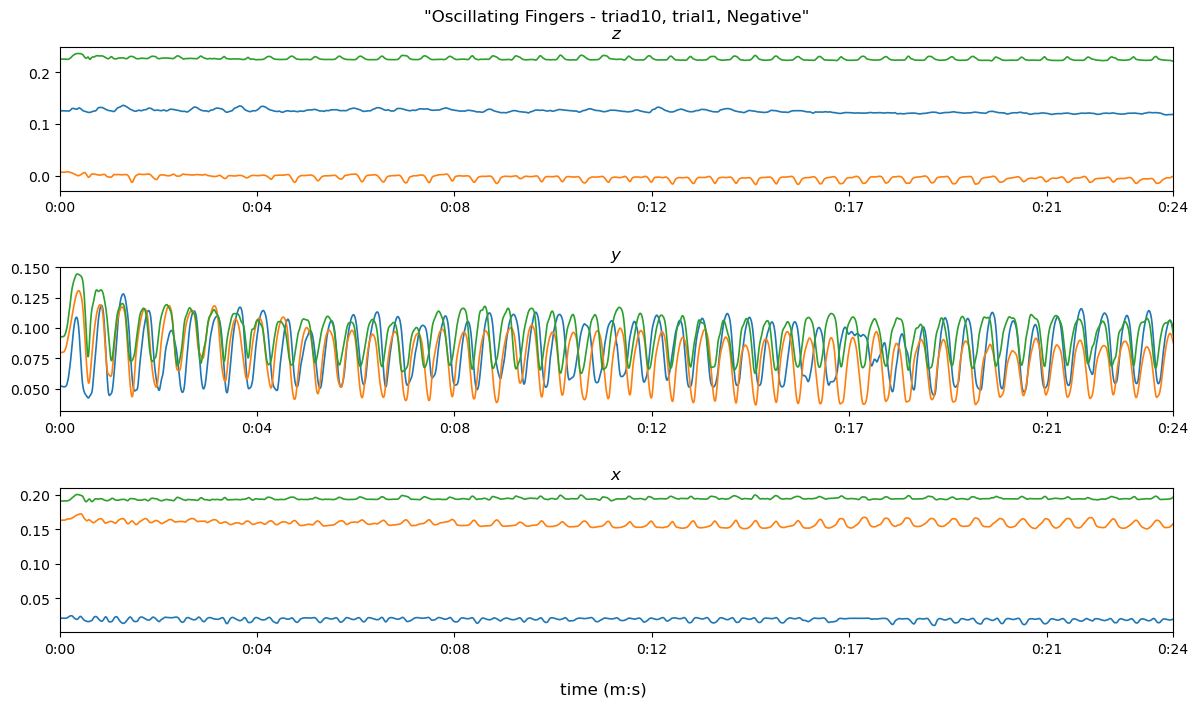

In [4]:
data_3D.visualise(top=0)

***
### Reduction to one dimension per point

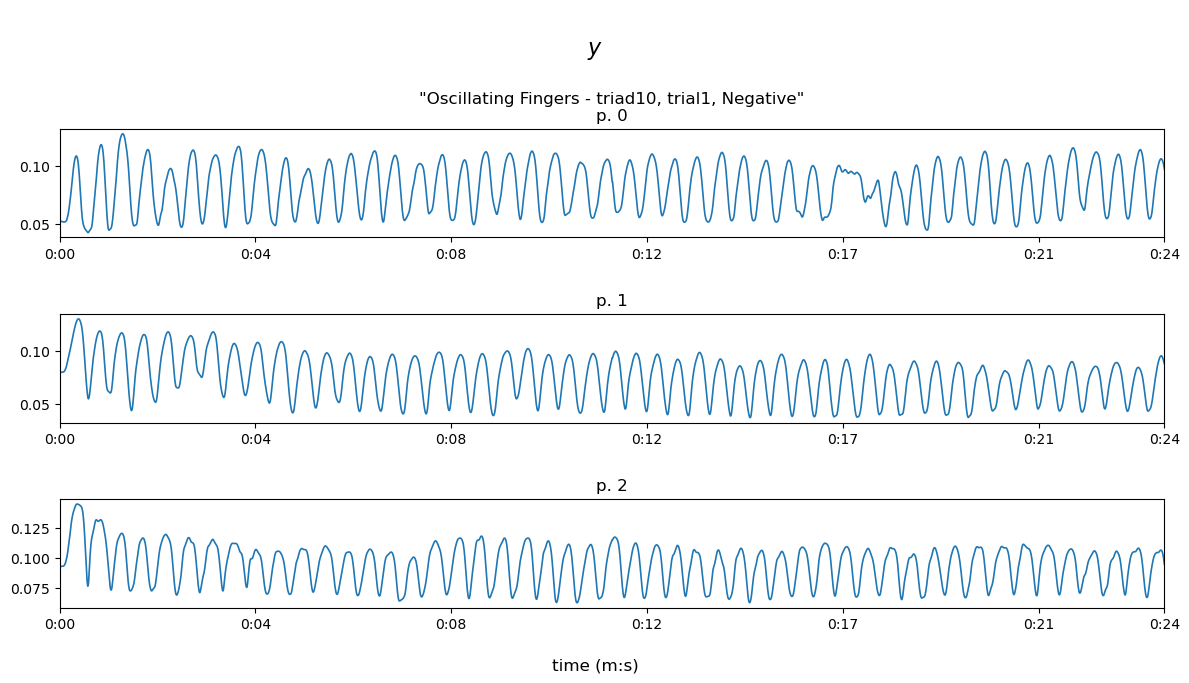

In [5]:
red1D_method = 'y' # <--- 'speed' or 'y'

if red1D_method == 'y':
    data_1D = sc.ptdata.select( data_3D, axis=1 )
elif red1D_method == 'speed':
    data_1D = sc.ptdata.speed( data_3D, dim=dim )
else: raise Exception('invalid value for red1D_method')
data_1D.visualise( top=0, groupby=None, vscale=0.9, dlattr='1.2' )

***
### Phase

>
#### Test for method of Smykovskyi et al. (2024):
According to the paper reporting the experiment (Smykovskyi et al., 2024) and a cited paper describing the procedure in more detail (Smykovskyi et al., 2022), data is locally detrended prior to computing phase. The detrending procedure first detects inflection points of speed (referred to as "raw velocity" or "total velocity" in the papers respectively) by taking the second derivative of position. Then, the inflection points are indexed where the second derivative of position is zero. However, the speed has no inflection points. Hence, its derivative has no points equal to zero.

In [6]:
if red1D_method == 'speed':
    select_triad = 1 # <---
    select_trial = 2 # <---
    select_point = 0 # <---
    keys_triad = data_1D.topinfo['triad'] == select_triad
    keys_trial = data_1D.topinfo['trial'] == select_trial
    key_data = data_1D.topinfo.index[keys_triad & keys_trial].item()
    selected_speed_signal = data_1D.data[key_data][select_point]
    idx_inflections = np.diff(selected_speed_signal, n=1)==0
    print('(diff == 0) =',np.any(idx_inflections))
else: print('diff test not applicable')

diff test not applicable


>
#### Extract phase from peaks:

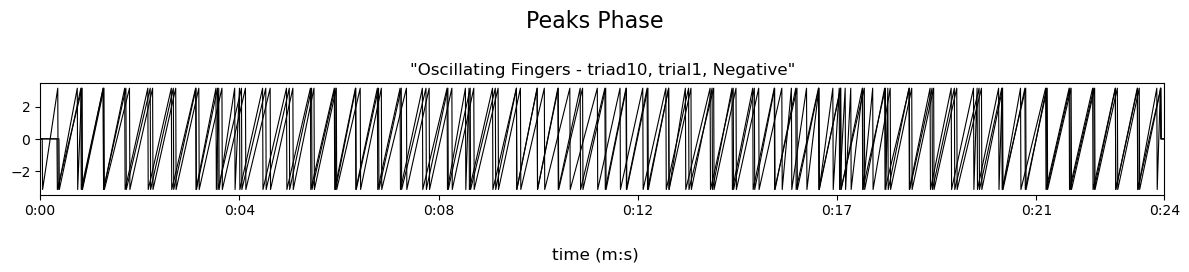

In [7]:
phase = sc.ptdata.peaks_to_phase( data_1D )
phase.visualise( top=0 )

***
### Synchronisation

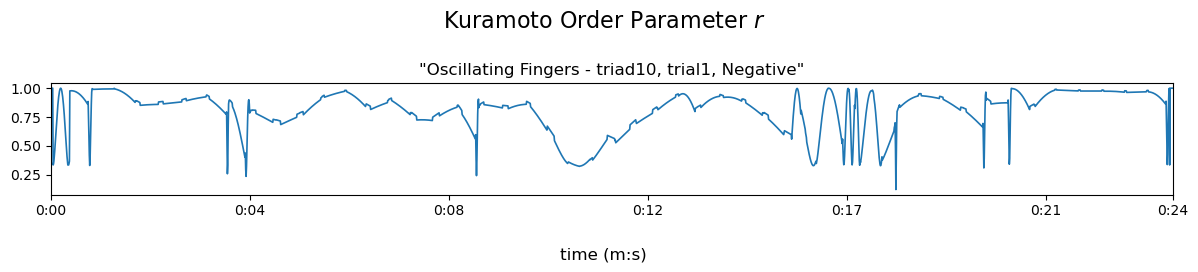

In [8]:
sync_method = 'r' # <--- 'r', 'Rho', or 'PLV'

if sync_method == 'r':
    sync_trials = sc.ptdata.kuramoto_r( phase )
elif sync_method == 'Rho':
    sync_trials = sc.ptdata.rho( phase )
elif sync_method == 'PLV':
    plv_window = 1 # <--- (seconds)
    sync_pairwise = sc.ptdata.winplv( phase, plv_window )
    sync_pairwise = sc.ptdata.apply( sync_pairwise, sc.utils.nanbordz, margin=120 )
    sync_pairwise.labels.main = 'PLV'
    sync_pairwise.visualise( top=0, dlattr='1', vscale=0.7 )
    sync_trials = sc.ptdata.aggrax( sync_pairwise, function='mean' )
    sync_trials.names.main = 'mean PLV'
else: raise Exception('invalid value for sync_method')
sync_trials.visualise( top=0 )

>
#### Group data into induced emotions and compute mean of each trial

In [9]:
sync_trials.topinfo.head(8)

,ID,Name,emotion,triad,trial,fps
0,triad10_trial1,"Oscillating Fingers - triad10, trial1, Negative",Negative,10,1,120.0
1,triad10_trial10,"Oscillating Fingers - triad10, trial10, Positive",Positive,10,10,120.0
2,triad10_trial11,"Oscillating Fingers - triad10, trial11, Negative",Negative,10,11,120.0
3,triad10_trial12,"Oscillating Fingers - triad10, trial12, Positive",Positive,10,12,120.0
4,triad10_trial13,"Oscillating Fingers - triad10, trial13, Positive",Positive,10,13,120.0
5,triad10_trial14,"Oscillating Fingers - triad10, trial14, Negative",Negative,10,14,120.0
6,triad10_trial15,"Oscillating Fingers - triad10, trial15, Neutral",Neutral,10,15,120.0
7,triad10_trial2,"Oscillating Fingers - triad10, trial2, Positive",Positive,10,2,120.0


In [10]:
emo_labels = ['Negative','Neutral','Positive']
sync_means_trials = {}
for e in emo_labels:
    keys_emo = sync_trials.topinfo.index[sync_trials.topinfo['emotion']==e].to_list()
    selection_emo = sc.ptdata.select( sync_trials, top=keys_emo )
    mean_emo = sc.ptdata.aggrax( selection_emo, function='mean' )
    concat_emo = sc.ptdata.aggrtop( mean_emo, 'concat' )
    sync_means_trials[e] = concat_emo.data[next(iter(concat_emo.data))]

>
#### Distribution of trials' synchrony measure and means, grouped by emotions

Negative (100 trials):
  SW-test statistic =  0.9681 , p-value = 0.0158 (non-normal)
  mean = 0.7486
Neutral (100 trials):
  SW-test statistic =  0.9668 , p-value = 0.0125 (non-normal)
  mean = 0.7445
Positive (99 trials):
  SW-test statistic =  0.9744 , p-value = 0.0507 (normal)
  mean = 0.7397


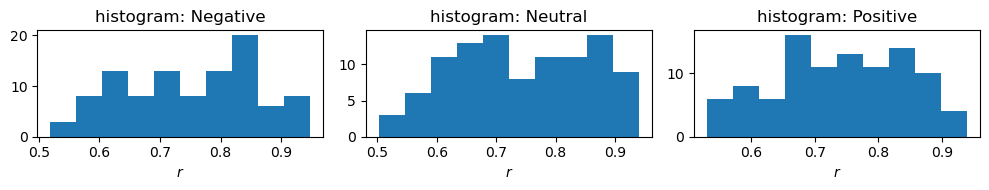

In [11]:
sw_alpha = 0.05 # <--- p-value theshold for Shapiro-Wilkins test

sync_means_emo = []
distr_str = []
plt.figure(figsize=(10,2))
for i_sp, (k,v) in enumerate(zip(sync_means_trials,sync_means_trials.values())):
    n_trials = len(v)
    this_emo_mean = np.nanmean(v)
    sync_means_emo.append(this_emo_mean)
    this_sw_test = stats.shapiro(v)
    if this_sw_test[1] >= sw_alpha: normality_lbl = 'normal'
    else: normality_lbl = 'non-normal'
    distr_str.append(normality_lbl)
    print(f'{k} ({n_trials} trials):')
    print('  SW-test statistic = ',round(this_sw_test[0],4),
          ', p-value =',round(this_sw_test[1],4), f'({normality_lbl})')
    print('  mean =', round(this_emo_mean,4))
    plt.subplot(1,3,i_sp+1)
    i_sp+=1
    plt.hist(v), plt.title(f'histogram: {k}')
    plt.xlabel(f'${sync_method}$')
plt.tight_layout()


>
#### Means

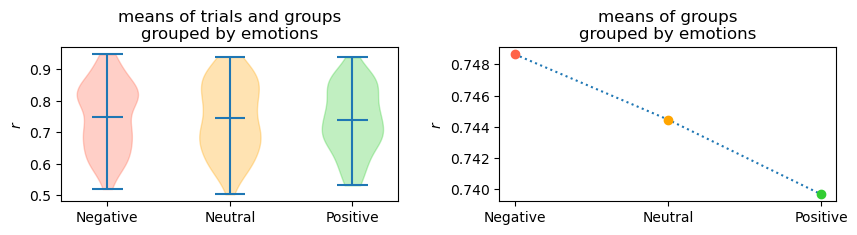

In [52]:
plot_colours = ['tomato','orange','limegreen']
plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
vp = plt.violinplot( sync_means_trials.values(), (0,1,2), showmeans=True );
for p,c in zip(vp['bodies'],plot_colours): p.set_color(c)
plt.title('means of trials and groups\ngrouped by emotions')
plt.ylabel(f'${sync_method}$')
plt.xticks((0,1,2),sync_means_trials.keys());
plt.subplot(1,2,2)
plt.plot(sync_means_emo,':')
for i,c in enumerate(plot_colours): plt.plot(i,sync_means_emo[i],marker='o',color=c)
plt.title('means of groups\ngrouped by emotions')
plt.ylabel(f'${sync_method}$')
plt.xticks([0,1,2],sync_means_trials.keys())
plt.subplots_adjust(wspace=0.3)

>
#### Analysis of variance

In [13]:
keys = list(sync_means_trials.keys())
hp = stats.kruskal( *sync_means_trials.values() ) # Kruskal-Wallis test (nonparametric one-way ANOVA)
print(f'H-test ANOVA:',f'\n  H =',round(hp[0],3),'\n  p value =',round(hp[1],4))

H-test ANOVA: 
  H = 0.265 
  p value = 0.8759
